# Optiver LSTM-based

### Trains a network architecture which relies on LSTMs to understand the time-series patterns in the price features in data
* Stock ID's are embedded in an Embedding layer
* Price Features are trained on an LSTM that forecasts six steps ahead (t + 60) and then combined with stock embedding data to produce the final prediction


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import sys
from IPython.display import clear_output

In [2]:
seed = 45

train_path = 'train.csv'
# test_path = 'optiver-trading-at-the-close/test.csv'

# Load into DataFrame
df_train_valid = pd.read_csv(train_path)
df_valid = df_train_valid.query('date_id > 476').copy()
df_train = df_train_valid.query('date_id <= 476').copy()

In [3]:
df_valid.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5193980,0,477,0,7485534.85,-1,1.000308,9375793.14,NaN,NaN,0.999958,9715.50,1.000133,30866.4,1.0,-2.310276,26235,477_0_0
5193981,1,477,0,0.00,0,0.999203,2078442.76,NaN,NaN,0.999203,8020.80,1.000498,5019.5,1.0,-12.850165,26235,477_0_1
5193982,2,477,0,3064803.52,1,1.000875,3905992.62,NaN,NaN,0.999949,777.04,1.001287,19452.0,1.0,-0.439882,26235,477_0_2
5193983,3,477,0,2667930.04,-1,0.999889,30560587.60,NaN,NaN,0.999740,30321.00,1.000087,10110.5,1.0,7.259846,26235,477_0_3
5193984,4,477,0,3338600.62,-1,1.000469,9342694.05,NaN,NaN,0.999961,1772.20,1.000695,31568.3,1.0,4.780292,26235,477_0_4


In [4]:
def preprocess(df):
    """
    Absolute bare minimal preprocessing for the Optiver dataset
    """

    # Fill NaNs in near_price and far_price with reference_price
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    df['far_price'] = df['far_price'].fillna(df['reference_price'])
    df['wap'] = df['wap'].fillna(df['reference_price'])
    
    # Subtract mean from price features, grouped by stock_id
    price_features = ['ask_price', 'bid_price', 'near_price', 'far_price', 'reference_price', 'wap']
    for feature in price_features:
        df[feature] = df.groupby('stock_id')[feature].transform(lambda x: x - x.mean())

    # Drop row_id and time_id, not needed for training
    df = df.drop(['row_id', 'time_id'], axis=1).dropna()
    df.sort_values(['stock_id', 'date_id', 'seconds_in_bucket'], ignore_index=True, inplace=True)
    targets = df['target']
    return_df = df.drop(['target'], axis=1)


    return return_df, targets

In [5]:
def preprocess_test(df):
    """
    Preprocess test data similarly to training data
    """
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    df['far_price'] = df['far_price'] = df['reference_price']
    df['wap'] = df['wap'].fillna(df['reference_price'])

In [6]:
X_train, y_train = preprocess(df_train)
X_val, y_val = preprocess(df_valid)

In [7]:
def plot_moving_average(df, feature, stock_id):
    """
    Plots the 5-day moving average of a feature for a given stock_id.
    The average at each date_id is computed over date_id in [curr, curr+5].
    """
    # Filter for the given stock_id
    stock_df = df[df['stock_id'] == stock_id].copy()
    stock_df = stock_df.sort_values('date_id')
    
    # Group by date_id and compute mean for each day
    daily_means = stock_df.groupby('date_id')[feature].mean().reset_index()
    
    # Compute moving average over 5 days (window includes curr and next 4 days)
    daily_means['moving_avg'] = daily_means[feature].rolling(window=5, min_periods=1).mean().shift(-4)
    
    print('Average over all dates:', daily_means[feature].mean())
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_means['date_id'], daily_means[feature], label=f'Daily mean {feature}')
    plt.plot(daily_means['date_id'], daily_means['moving_avg'], label='5-day moving average', linewidth=2)
    plt.xlabel('date_id')
    plt.ylabel(feature)
    plt.title(f'5-Day Moving Average of {feature} for stock_id {stock_id}')
    plt.legend()
    plt.show()

Average over all dates: -1.372177179708195e-16


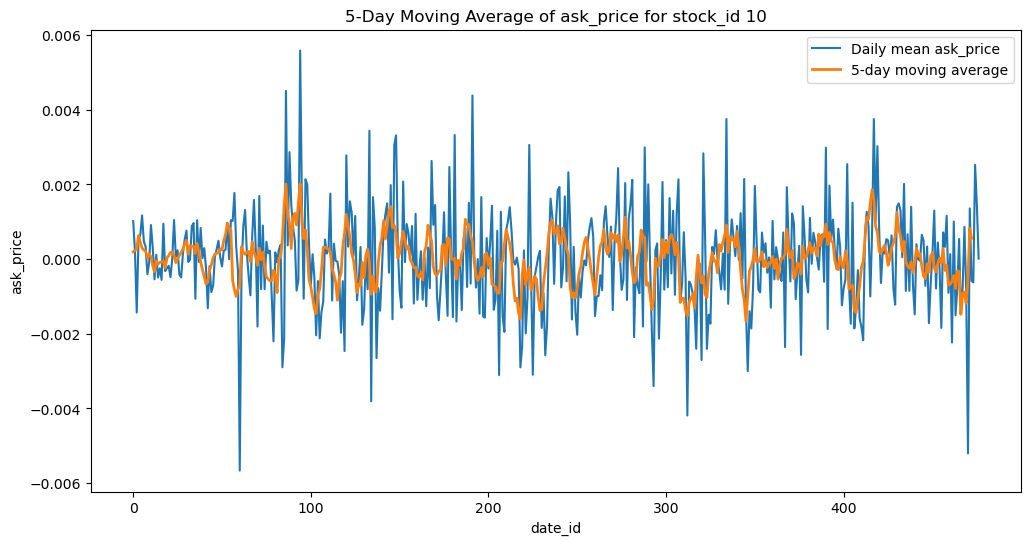

In [8]:
plot_moving_average(X_train, 'ask_price', 10)

In [9]:
X_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap'],
      dtype='object')

In [10]:
def return_padded_df(df, stock, date, seq_len):
    """
    Returns a padded DataFrame with the last seq_len rows of df.
    """
    if len(df) >= seq_len:
        return df.tail(seq_len)
    else:
        pad_len = seq_len - len(df)
        pads = []
        for i in range(0, pad_len):
            pads.insert(0, {'stock_id': stock, 'date_id': date, 'seconds_in_bucket': int(-10*(i+1)), 
                        'imbalance_size':0, 'imbalance_buy_sell_flag': 0,
                        'reference_price': 0, 'matched_size':0, 'near_price': 0, 
                        'wap': 0, 'far_price': 0, 'ask_price': 0, 'bid_price': 0,
                        'bid_size':0, 'ask_size': 0})
        pads_df = pd.DataFrame(pads)
        return pd.concat([pads_df, df])

## Prepare dataset for training

In [11]:
def batch_for_ts(df, seq_len):
    """
    Returns a list of padded DataFrames for each time series in df.
    """
    ts_features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'near_price', 'wap']
    timestamps = df['seconds_in_bucket'].unique()
    dates = df['date_id'].unique()
    stocks = df['stock_id'].unique()

    batches = []
    counter = 0
    print("Generating batches ...")
    for date in dates:
        if date % 5 == 0:
            percent_done = int((counter/len(dates))*100)
            output_str = "["+ "*"*percent_done + " "*(100-percent_done) + "] " + str(percent_done) + "% done" + "\r"
            #Display progress bar
            sys.stdout.write(output_str)
            sys.stdout.flush()
        for stock in stocks:
            temp_df = df.query(f'stock_id == {int(stock)} and date_id == {int(date)}').sort_values('seconds_in_bucket').copy()
            for i in range(0, len(temp_df)):
                batches.insert(len(batches), return_padded_df(temp_df[:i+1], stock, date, seq_len))
            del temp_df
        counter += 1
    return batches

In [12]:
train_batches = batch_for_ts(X_train, 6)
valid_batches = batch_for_ts(X_val, 6)

Generating batches ...
Generating batches ...****************************************************************************** ] 99% done


In [13]:
# Process batches so that they can be used in a DataLoader
class OptiverDataset(Dataset):
    def __init__(self, batches, y, seq_len):
        self.seq_len = seq_len
        self.y = y
        self.batches = batches
        self.ts_features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'near_price', 'wap']

    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        batch = self.batches[idx]
        stock_id = batch['stock_id'].values[0]
        date_id = batch['date_id'].values[0]
        ts = batch[self.ts_features].values.astype(np.float32)
        target = self.y[idx]
        return (
            torch.tensor(stock_id, dtype=torch.float32),
            torch.tensor(date_id, dtype=torch.float32),
            torch.tensor(ts, dtype=torch.float32),
            torch.tensor(target, dtype=torch.float32)
        )

In [14]:
train_dataset = OptiverDataset(train_batches, y_train, 6)
val_dataset = OptiverDataset(valid_batches, y_val, 6)

In [ ]:
val_dataset[0]

(tensor(0.),
 tensor(477.),
 tensor([[-5.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-4.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-3.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-2.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-1.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  7.4855e+06, -1.0000e+00,  6.2555e-04,  5.5921e-03,
           2.9550e-04]]),
 tensor(-2.3103))

In [15]:
# --------------------
# Model Definition
# --------------------
class OptiverModel(nn.Module):
    def __init__(self, 
                 n_stocks = 200,  
                 stock_emb_dim=3, 
                 lstm_input_dim=7, 
                 lstm_hidden_dim=32, 
                 lstm_layers=1, 
                 forecast_horizon=6):
        super().__init__()
        
        # self.meta_fc = nn.Sequential(
        #     nn.Linear(2, 4),  # stock_id and date_id as raw floats/ints
        #     nn.ReLU()
        # )

        # Embedding layer for stock_id
        self.stock_emb = nn.Embedding(n_stocks, stock_emb_dim)


        
        # LSTM for historical time-series features
        self.lstm = nn.LSTM(input_size=lstm_input_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True)
        
        # Project LSTM last hidden state to forecast horizon × feature_dim
        self.lstm_out = nn.Linear(lstm_hidden_dim, forecast_horizon * lstm_input_dim)
        self.forecast_horizon = forecast_horizon
        self.lstm_input_dim = lstm_input_dim
        
        # Final fully connected layer: fuse metadata + forecast (+6 step only)
        fused_dim = stock_emb_dim + lstm_input_dim
        self.final_fc = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # predict target
        )

    def forward(self, stock_id, ts_features):
        """
        stock_id: (batch,)
        date_id: (batch,)
        ts_features: (batch, seq_len, lstm_input_dim)
        """
        # Embedding features
        stock_vec = self.stock_emb(stock_id)

        # Ensure inputs are float (if needed)
        # stock_date = torch.stack([stock_id, date_id], dim=1)  # shape (batch, 2)

        
        # LSTM forecast
        lstm_out, _ = self.lstm(ts_features)         # (batch, seq_len, hidden_dim)
        last_hidden = lstm_out[:, -1, :]              # take last time step
        forecast = self.lstm_out(last_hidden)         # (batch, horizon * input_dim)
        forecast = forecast.view(-1, self.forecast_horizon, self.lstm_input_dim)
        forecast_6 = forecast[:, -1, :]               # only +6 step
        
        # Fuse metadata with +6 step forecast
        fused = torch.cat([stock_vec, forecast_6], dim=-1)
        target_pred = self.final_fc(fused)            # (batch, 1)
        
        return target_pred


Training takes FOREVER. Need to modify the OptiverDataset class to calculate all the batches before training starts. X.query() is an expensive operation. 
By my estimate, training a single epoch will take around 36 days on M4 MBA.

In [ ]:
# --- Hyperparameters ---
import time
SEQ_LEN = 6  
BATCH_SIZE = 88
EPOCHS = 5
LR = 1e-3
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {DEVICE}")
start = time.time()

# --- Datasets & Loaders ---
# train_dataset = dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset   = OptiverDataset(X_val, y_val, seq_len=SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Model, Loss, Optimizer ---
model = OptiverModel(
    n_stocks=int(X_train['stock_id'].nunique()),
    stock_emb_dim=3,
    lstm_input_dim=len(train_dataset.ts_features),
    lstm_hidden_dim=32,
    lstm_layers=2,
    forecast_horizon=6
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
start = time.time()

# --- Training & Validation Loop ---
for epoch in range(EPOCHS):
    # Training
    print("Training Epoch:", epoch + 1)
    model.train()
    train_loss = 0
    counter = 0

    for stock, date, ts, target in train_loader:
        # Print progress bar
        if counter % int(0.011*len(train_loader)) == 0:
            clear_output(wait=True)
            percent_done = int((counter / len(train_loader)) * 100)
            output_str = "[" + "*" * percent_done + "-" * (100 - percent_done) + "] " + str(percent_done) + "% done" 

            if percent_done > 0:
                time_left = (100 - percent_done)*(time.time() - start)/(60*percent_done)
                time_left_str = "\nEstimated time left in Epoch: " + str(round(time_left, 2)) + " minutes" 
            else: 
                time_left_str = ""
            sys.stdout.write(output_str + time_left_str + "\r")
            sys.stdout.flush()

        stock  = stock.long().to(DEVICE) 
        date   = date.float().to(DEVICE)
        ts     = ts.to(DEVICE)
        target = target.float().unsqueeze(1).to(DEVICE)

        optimizer.zero_grad()
        preds = model(stock, ts)
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * stock.size(0)
        counter += 1
        

    train_loss /= len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for stock, date, ts, target in val_loader:
            stock  = stock.long().to(DEVICE)
            date   = date.float().to(DEVICE)
            ts     = ts.to(DEVICE)
            target = target.float().unsqueeze(1).to(DEVICE)

            preds = model(stock, date, ts)
            loss = criterion(preds, target)
            val_loss += loss.item() * stock.size(0)

    val_loss /= len(val_dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")


[************************************----------------------------------------------------------------] 36% done
